In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [5]:
block_size = 3
  
def build_dataset(words):
  X, Y = [],[]
  for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + ".":
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [118]:
g = torch.Generator().manual_seed(2147483647)

class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters trained with backprops
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers - trained with a running momentum update
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean / torch.sqrt(xvar + self.eps))
        self.out = self.gamma * xhat + self.beta
        # update the buffer
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var  = (1 - self.momentum) * self.running_var  + self.momentum * xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
n_emb = 10
n_hidden = 100

C = torch.randn((vocab_size, n_emb), generator=g)

layers = [
    Linear(n_emb * block_size,   n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden,   n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden,   n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden,   n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden,   n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size), 
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
    # make the last layer weights less confident
    # layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1
    # apply the gain for all other Linear layers (5/(3 since we are using tanh)
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47024


In [119]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # construct mini-batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    
    loss = F.cross_entropy(x, Yb)
    
    # backward pass
#     for layer in layers:
#         layer.out.retain_grad()

    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 100000 else 0.01 # lrs[i]
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    
#     with torch.no_grad():
#         ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
#     if i > 1000:
#         break

      0/ 200000: 3.4843
  10000/ 200000: 1.9361
  20000/ 200000: 2.4030
  30000/ 200000: 2.2041
  40000/ 200000: 1.9804
  50000/ 200000: 2.0596
  60000/ 200000: 2.0973
  70000/ 200000: 2.0391
  80000/ 200000: 1.8500
  90000/ 200000: 1.8456
 100000/ 200000: 1.8825
 110000/ 200000: 1.9097
 120000/ 200000: 2.1742
 130000/ 200000: 2.0782
 140000/ 200000: 2.2442
 150000/ 200000: 2.2754
 160000/ 200000: 2.3303
 170000/ 200000: 2.0747
 180000/ 200000: 2.2169
 190000/ 200000: 1.8064


layer 2 (      Tanh): mean -0.01, std 0.62, saturated: 2.72%
layer 5 (      Tanh): mean -0.01, std 0.51, saturated: 0.22%
layer 8 (      Tanh): mean -0.01, std 0.49, saturated: 0.34%
layer 11 (      Tanh): mean +0.02, std 0.51, saturated: 1.03%
layer 14 (      Tanh): mean +0.01, std 0.62, saturated: 4.88%


Text(0.5, 1.0, 'activation distribution')

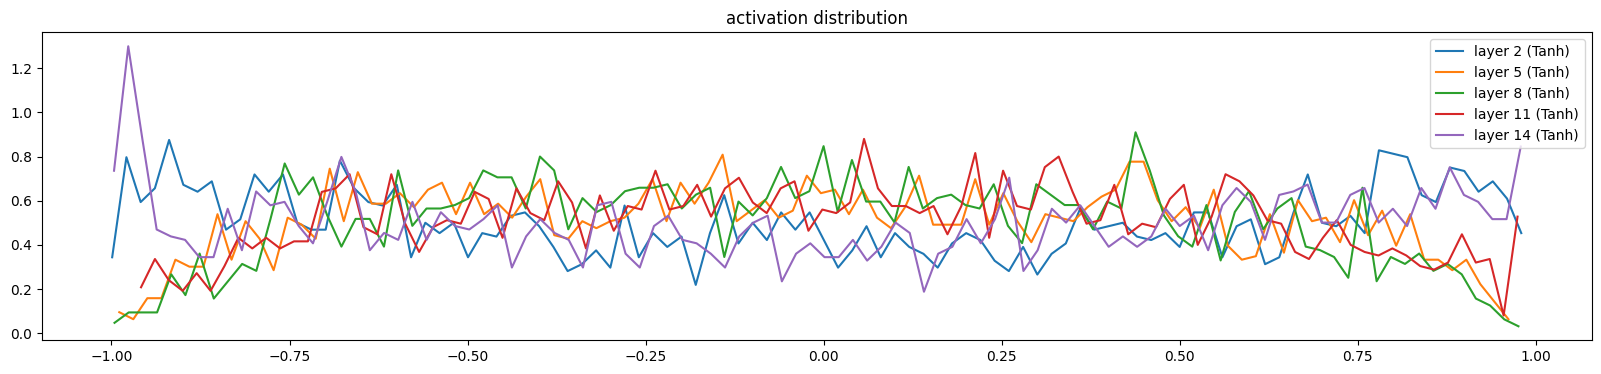

In [112]:
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]): # exclude last layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
        
plt.legend(legends)
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000030, std 2.701196e-03
layer 5 (      Tanh): mean -0.000024, std 2.464696e-03
layer 8 (      Tanh): mean +0.000003, std 2.252940e-03
layer 11 (      Tanh): mean +0.000007, std 2.098682e-03
layer 14 (      Tanh): mean -0.000012, std 2.302737e-03


Text(0.5, 1.0, 'gradient distribution')

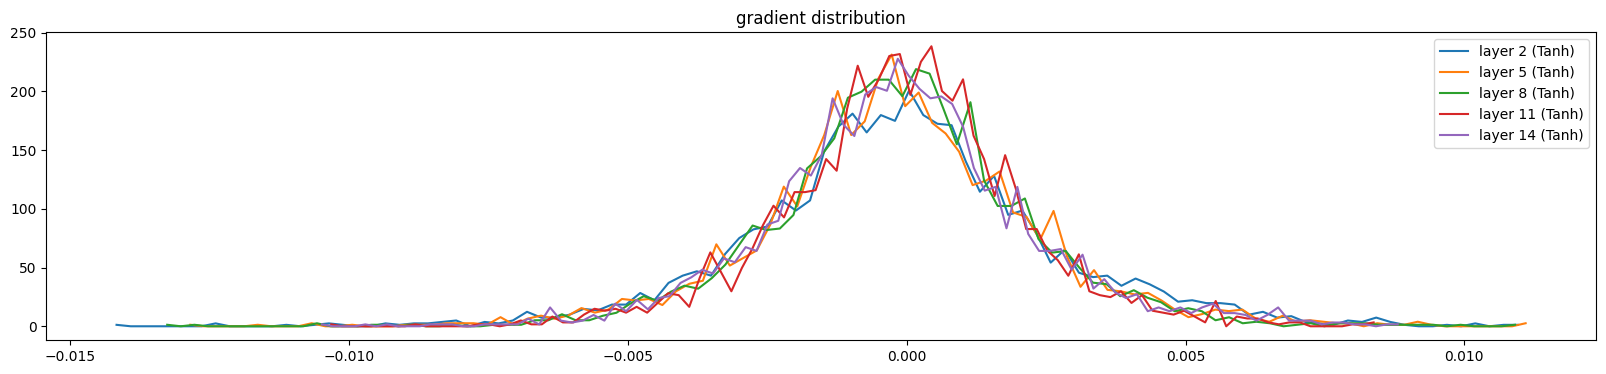

In [113]:
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]): # exclude last layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
        
plt.legend(legends)
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000024 | std 1.071695e-02 | grad:data ratio 1.067768e-02
weight  (30, 100) | mean -0.000530 | std 1.033044e-02 | grad:data ratio 5.437231e-02
weight (100, 100) | mean -0.000149 | std 6.887374e-03 | grad:data ratio 6.746753e-02
weight (100, 100) | mean +0.000085 | std 5.048664e-03 | grad:data ratio 4.937943e-02
weight (100, 100) | mean -0.000047 | std 4.559941e-03 | grad:data ratio 4.484272e-02
weight (100, 100) | mean +0.000007 | std 4.421353e-03 | grad:data ratio 4.336082e-02
weight  (100, 27) | mean -0.000020 | std 1.080549e-02 | grad:data ratio 9.944763e-02


Text(0.5, 1.0, 'weights gradient distribution')

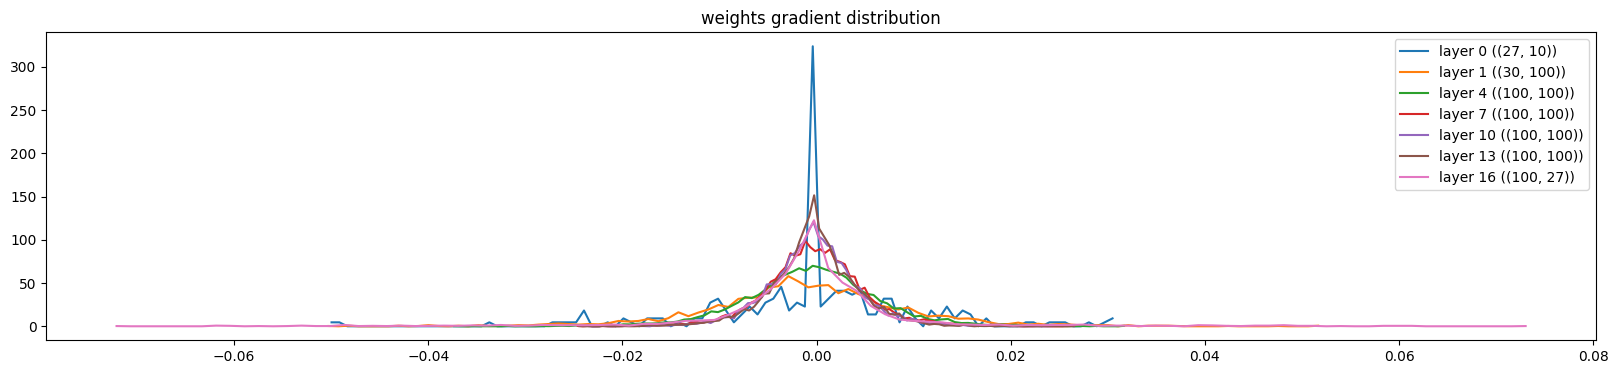

In [114]:
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters): # exclude last layer
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({tuple(p.shape)})')
        
plt.legend(legends)
plt.title('weights gradient distribution')

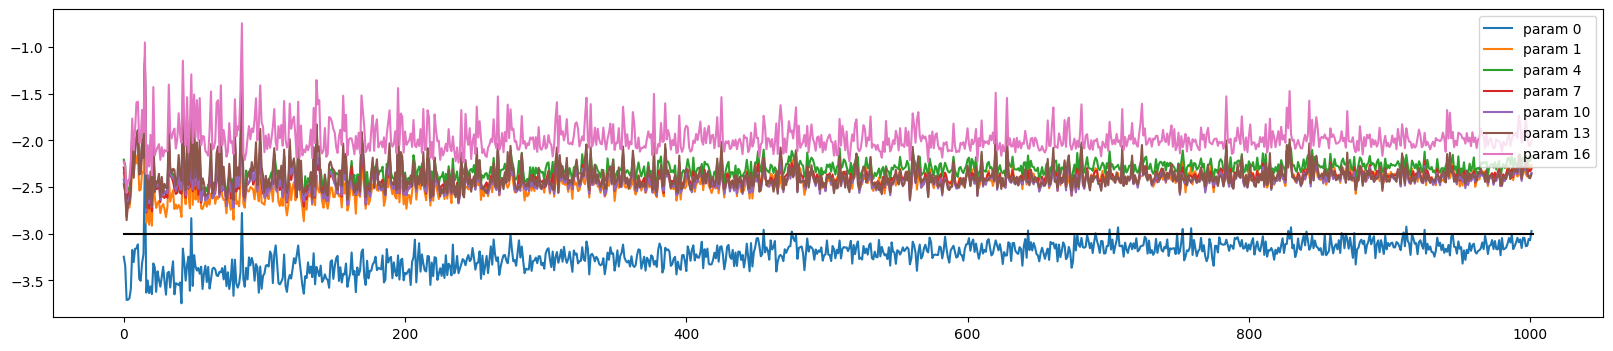

In [116]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


In [120]:
@torch.no_grad()
def split_loss(split):
    x, y = {
      "train": (Xtr, Ytr),
      "val": (Xdev, Ydev),
      "test": (Xte, Yte),
    }[split]
    emb = C[x]
    xdash = emb.view(emb.shape[0], -1)
    for layer in layers:
        xdash = layer(xdash)
    loss = F.cross_entropy(xdash, y)
    print(split, loss.item())

# put the layers in eval mode
for layer in layers:
    layer.training = False

split_loss('train')
split_loss('val')

train 2.0042035579681396
val 2.0926764011383057


In [121]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        x = emb.view(1, -1)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carlah.
amillivia.
jarri.
tatyanna.
sane.
mahni.
faretarti.
aquie.
ramari.
chaiir.
kaleigh.
ham.
port.
quintis.
lilea.
jadiq.
wavero.
dearisi.
jace.
pilsa.


BONUS CONTENT FROM COLLAB - https://colab.research.google.com/drive/1H5CSy-OnisagUgDUXhHwo1ng2pjKHYSN?usp=sharing#scrollTo=Ak-nkUivsa6O

In [3]:
# BatchNorm forward pass as a widget

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np

def normshow(x0):
    g = torch.Generator().manual_seed(2147483647+1)
    x = torch.randn(5, generator=g) * 5
    x[0] = x0 # override the 0th example with the slider
    mu = x.mean()
    sig = x.std()
    y = (x - mu)/sig

    plt.figure(figsize=(10, 5))
    # plot 0
    plt.plot([-6,6], [0,0], 'k')
    # plot the mean and std
    xx = np.linspace(-6, 6, 100)
    plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b')
    xx = np.linspace(-6, 6, 100)
    plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')
    # plot little lines connecting input and output
    for i in range(len(x)):
        plt.plot([x[i],y[i]], [1, 0], 'k', alpha=0.2)
    # plot the input and output values
    plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)
    plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100)
    plt.xlim(-6, 6)
    # title
    plt.title('input mu %.2f std %.2f' % (mu, sig))

interact(normshow, x0=(-30,30,0.5));


interactive(children=(FloatSlider(value=0.0, description='x0', max=30.0, min=-30.0, step=0.5), Output()), _dom…

In [4]:
# Linear: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000,1), requires_grad=True, generator=g)          # a.grad = b.T @ c.grad
b = torch.randn((1000,1000), requires_grad=True, generator=g)       # b.grad = c.grad @ a.T
c = b @ a
loss = torch.randn(1000, generator=g) @ c
a.retain_grad()
b.retain_grad()
c.retain_grad()
loss.backward()
print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item())
print('-----')
print('c grad std:', c.grad.std().item())
print('a grad std:', a.grad.std().item())
print('b grad std:', b.grad.std().item())

a std: 0.9875972270965576
b std: 1.0006722211837769
c std: 31.01241683959961
-----
c grad std: 0.9782556295394897
a grad std: 30.8818302154541
b grad std: 0.9666601419448853


In [7]:
# Linear + BatchNorm: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

n = 1000
# linear layer ---
inp = torch.randn(n, requires_grad=True, generator=g)
w = torch.randn((n, n), requires_grad=True, generator=g)  #/ n**0.5
x = w @ inp
# bn layer ---
xmean = x.mean()
xvar = x.var()
out = (x - xmean) / torch.sqrt(xvar + 1e-5)
# ----
loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print('inp std: ', inp.std().item())
print('w std: ', w.std().item())
print('x std: ', x.std().item())
print('out std: ', out.std().item())
print('------')
print('out grad std: ', out.grad.std().item())
print('x grad std: ', x.grad.std().item())
print('w grad std: ', w.grad.std().item())
print('inp grad std: ', inp.grad.std().item())

inp std:  0.9875972270965576
w std:  1.0006722211837769
x std:  31.01241683959961
out std:  1.0
------
out grad std:  0.9782556295394897
x grad std:  0.031543977558612823
w grad std:  0.031169468536973
inp grad std:  0.9953053593635559
